# Project 3: Web APIs & NLP

---
# Part 3 - Preprocessing, Modelling
### Notebook 3 - Contents:

**[3.1 Preprocessing](#3.1-Preprocessing)** <br>

[3.1.1 Stopwords](#3.1.1-Stopwords)
[3.1.2 Train Test Split](#3.1.2-Train-Test-Split)<br>
    
**[3.2 Modelling](#3.2-Modelling)** <br>

[3.2.1 Logistic Regression](#3.2.1-Logistic-Regression)<br>
        - [Base Model - CVEC, LogReg](#Base-Model---CVEC,-LogReg)<br>

[3.2.2 Model Evaluation Metrics](#3.2.2-Model-Evaluation-Metrics)<br>

[3.2.3 Naive Bayes](#3.2.3-Naive-Bayes)<br>
    - [Model 1A - CVEC, NB](#Model-1A---CVEC,-NB)<br>
    - [Model 1B - TF-IDF, NB](#Model-1B---TF-IDF,-NB)<br>
    
[3.2.4 Random Forests](#3.2.4-Random-Forests)<br>
    - [Model 2A - CVEC, Random Forests](#Model-2A---CVEC,-Random-Forests)<br>
    - [Model 2B - TF-IDF, Random Forests](#Model-2B---TF-IDF,-Random-Forests)<br>
    
[3.2.5 ADABoost](#3.2.5-ADABoost)<br>
    - [Model 3 - TF-IDF, ADAboost](#Model-3---TF-IDF,-ADAboost)<br>
    
[3.2.6 Support Vector Machines](#3.2.6-Support-Vector-Machines)<br>
    - [Model 4 - TF-IDF, SVM](#Model-4---TF-IDF,-SVM)<br>

[3.2.7 Summary of Model Performance](#3.2.7-Summary-of-Model-Performance)<br>

[3.2.8 Analysis of NB model's Coefficients](#3.2.8-Analysis-of-NB-model's-Coefficients) <br>

**[3.3 Conclusion](#3.3-Conclusion)** <br>

[3.3.1 Addressing the Problem Statement](#3.3.1-Addressing-the-Problem-Statement)<br>
[3.3.2 Limitations and Recommendations](#3.3.2-Limitations-and-Recommendations)<br>

---

In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [349]:
#load picked df
df_text = pickle.load(open('../model/df_text.pkl', 'rb'))

In [350]:
print(df_text.shape)
df_text.head()

(24874, 2)


,subreddit,title_selftext
1,1,programmers what are the greatest issues you ...
2,1,you s hiring managers how diverse is your ap...
3,1,do i need a masters i am going into my second...
4,1,how do you describe your job when someone asks...
5,1,how i quickly rose to senior data scientist an...


# 3.1 Preprocessing

## 3.1.1 Stopwords
The dataset that is brought in, has already undergone one round of cleaning, tokenization and lemmatization in notebook_2. However, as we further refine the model, we can continue to improve on the function below to cleanup more observed errors in the text.

In [328]:
#import stopwords from notebook 2
file_path = "../data/final_stopwords.txt"
final_stopwords = np.loadtxt(file_path, dtype=str)

In [329]:
len(final_stopwords)

218

Various sets of blanket stopwords were tried out with the base model (CVEC, LogReg) to see which set could yield a better preliminary score. Ultimately, these blanket sets were too aggressive and this probably caused data loss and led to alot of crucial two-gram or three-gram words being lost. As a result, the blanket sets with larger numbers of stop words resulted in worse accuracy test scores.

|  | Stopwords Description | No of stopwords | Base model Testscore |
|----|----|----|----|
| **1)** | NLTK English stopwords + <br> handpicked stopwords | 208 | 0.7516 |
| **2)** | NLTK English stopwords + <br> handpicked stopwords + <br>bottom 5 percentile of feature words from each subreddit  | 12000+ | 0.7511 |
| **3)** | NLTK English stopwords + <br> handpicked stopwords + <br>all common words between both subreddits  | 12000+ | 0.6436 |

It was concluded that we should proceed with option 1 - the NLTK 'english' stopwords, together with some additional handpicked stopwords from our EDA in notebook 2.

---
## 3.1.2 Train Test Split

In [330]:
df_text.tail()

,subreddit,title_selftext
11735,0,no i am sorry i did not think like that i a...
11736,0,used it it is pretty nice already have tools...
11737,0,i am struggling to see what this adds that i c...
11738,0,thanks for giving it a shot it is a great wor...
11739,0,of course there is a lot of overlap with othe...


In [331]:
X = df_text['title_selftext']
y = df_text['subreddit']

In [332]:
# Check y proportions
y.value_counts(normalize = True)

1    0.517247
0    0.482753
Name: subreddit, dtype: float64

From the value counts, we can see that our model has a rather balanced class distribution, with ratio being almost 0.5. This is ideal, as there is less bias, and a higher chance that evaluation metrics are more reliable. Balanced classes help the model learn patterns from both classes, leading to better generalization and performance. Nevertheless, we should still use stratify=y to account for the slight imbalance.

---
Train-test-split:

In [333]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

---
# 3.2 Modelling
## 3.2.1 Logistic Regression
### Base Model - CVEC, LogReg
As our base model, the logistic regression model was used as it is computationally efficient and works well on all sized datasets. This is allows us to do quicker tests (like when trying to see if certain feature cleaning techniques or stopwords, etc can improve accuracy). Logistic Regression also provides interpretable results. 

In [334]:
# Create a WordNet Lemmatizer object
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens


##### Lemmatization vs Stemming
Between lemmatizing and stemming, there is only a slight difference in scores. I decided to stick to using lemmatization as it was used earlier in notebook 2 to determine the stopwords. Lemmatization also retains the interpretibility of words.<br>
Additionally, running stopwords (which are not stemmed) now with the stemmer leads to warning errors. This is something to take note of in future.

In [335]:
pipe = Pipeline([
    ('cvec', CountVectorizer(tokenizer=tokenize_and_lemmatize, stop_words=list(final_stopwords), token_pattern=None)),
    ('lr', LogisticRegression(solver='liblinear'))
])

In [336]:
#Fit the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and_lemmatize at 0x00000190025DC3A0>)),
                ('lr', LogisticRegression(solver='liblinear'))])

In [337]:
#Train score
acc_tr = pipe.score(X_train, y_train)
print(f'Train Accuracy Score: {round(acc_tr, 4)}')

Train Accuracy Score: 0.9112


In [338]:
#Test score
acc_te = pipe.score(X_test, y_test)
print(f'Test Accuracy Score: {round(acc_te, 4)}')

Test Accuracy Score: 0.7481


### Findings - Log Reg
From our logreg base model, we can see quite drastic overfitting in the model. For later models, we should use grid search to help us narrow down on the ideal hyperparameters to be used to reduce overfitting.<br>Parameters like max feature selection, regularisation could help us reduce overfitting.

---
## 3.2.2 Model Evaluation Metrics
To evaluate the models, the metrics of **Accuracy** and **F1 Score** will be used.

* **Accuracy**: Since the goal is to classify comments and queries into data science or data engineering categories, an accurate measure of how often the model is correct is of primary importance. Our dataset used for the training model is also relatively balanced.

* **F1 Score**: (the harmonic mean of precision and recall) As my model is just slightly imbalanced (0.51:0.48 ratio), i decided to consider F1 score as it is a good overall measure to balance precision and recall. Since the model would be used to categorize the comments and queries from the GA open discussion platform into the categories of data science or data engineering, we do not need to prioritize predicting of positives or negatives. This metric is hence useful when the consequences of false positives and false negatives are not heavily skewed.

* Specificity measures the proportion of actual negatives that are correctly predicted as negatives. Sensitivity measures the proportion of actual positives that are correctly predicted as positives. Precision measures the proportion of predicted positives that are actually positive. <br>Since we have no priority in predicting positive or negative cases as we are mainly sorting comments/queries, we do not particularly need to evaluate specificity, sensitivity or precision.

* In essence, the combined use of accuracy and the F1 Score offers a comprehensive evaluation strategy that considers both the balanced nature of the dataset and the specific nuances of the categorization task, ensuring a robust assessment of the model's performance.


### Performance Metrics Functions

Create a function that prints all the performance metrics for our models (TRAIN), as well as the confusion matrix:

In [339]:
def perf_measure_train(model, X_train, y_train):
    
    #Input model, X_test and y_test -- Output Accuracy, Sensitibity, Specificity, Precision, F1 Score
    y_pred_tr = model.predict(X_train)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_tr).ravel()
    cm = confusion_matrix(y_train, y_pred_tr)
    
    print('MODEL PERFORMANCE:')
    # accuracy = (tn + tp) / (tn + fp + fn + tp) 
    accuracy = accuracy_score(y_train, y_pred_tr) 
    print(f'Accuracy: {round(accuracy, 4)}')
    
    # f1score = 2 * (precision*sensitivity) / (precision + sensitivity)
    f1score = f1_score(y_train, y_pred_tr)
    print(f'F1 score: {round(f1score, 4)}')
    

Create a function that prints all the performance metrics for our models (TEST), as well as the confusion matrix:

In [340]:
def perf_measure_test(model, X_test, y_test):
    
    #Input model, X_test and y_test -- Output Accuracy, Sensitibity, Specificity, Precision, F1 Score
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot();
    
    print('MODEL PERFORMANCE:')
    # accuracy = (tn + tp) / (tn + fp + fn + tp) 
    accuracy = accuracy_score(y_test, y_pred) 
    print(f'Accuracy: {round(accuracy, 4)}')
    
    # f1score = 2 * (precision*sensitivity) / (precision + sensitivity)
    f1score = f1_score(y_test, y_pred)
    print(f'F1 score: {round(f1score, 4)}')


Create a function to plot precision-recall curve:

In [363]:
def plot_precision_recall_curve(model, X_test, y_test):
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    # Plot Precision-Recall curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', marker='o', markersize=1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()


---
## 3.2.3 Naive Bayes
Next, Naive Bayes model was explored. This model is selected as it is relatively fast to train and make predictions, making it suitable for real-time or large-scale applications like the open discussion platform that GA plans to implement. Naive Bayes is also good for Text Classification - it is commonly used for text classification tasks due to its efficiency and ability to handle high-dimensional, sparse data like word frequencies.

### Model 1A - CVEC, NB

In [344]:
#load picked models
gs_cvecnb = pickle.load(open('../model/gs_cvecnb.pkl', 'rb'))
best_model_cvecnb = pickle.load(open('../model/best_model_cvecnb.pkl', 'rb'))

In [343]:
pipe = Pipeline([
    ('cvec', CountVectorizer(tokenizer=tokenize_and_lemmatize, stop_words = list(final_stopwords), token_pattern=None)),
    ('nb', MultinomialNB())
])

In [ ]:
pipe_params = {
    'cvec__max_features': [5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
}

In [ ]:
gs_cvecnb = GridSearchCV(pipe,
                  param_grid=pipe_params, 
                  cv=5,
                  error_score='raise') 

In [ ]:
#Train pipeline on training data
gs_cvecnb.fit(X_train, y_train)

In [345]:
best_score_cvecnb = gs_cvecnb.best_score_
best_params_cvecnb = gs_cvecnb.best_params_
best_model_cvecnb = gs_cvecnb.best_estimator_

print(best_score_cvecnb)
print(best_params_cvecnb)
print(best_model_cvecnb)

0.762112717615816
{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=3,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and_lemmatize at 0x00000190025DC3A0>)),
                

In [ ]:
# Train the best model on the full training data
best_model_cvecnb.fit(X_train, y_train)

In [346]:
# Score model on training set.
perf_measure_train(best_model_cvecnb, X_train, y_train)

MODEL PERFORMANCE:
Accuracy: 0.7793
F1 score: 0.8002


MODEL PERFORMANCE:
Accuracy: 0.7752
F1 score: 0.7973


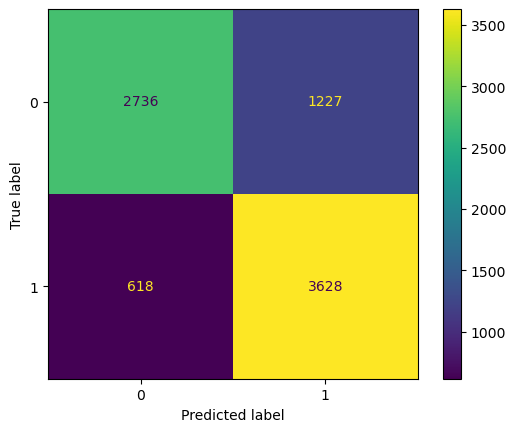

In [347]:
# Score model on testing set.
perf_measure_test(best_model_cvecnb, X_test, y_test)

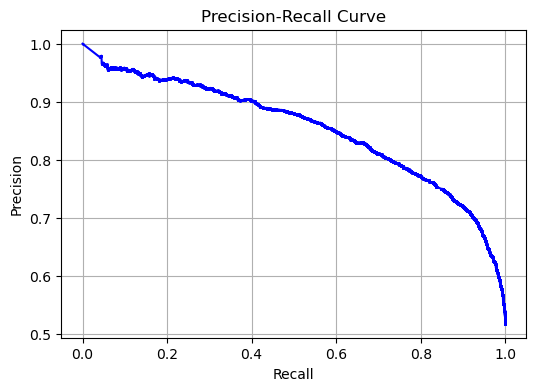

In [364]:
plot_precision_recall_curve(best_model_cvecnb, X_test, y_test)

---
### Model 1B - TF-IDF, NB

In [237]:
#load picked models
gs_tvecnb = pickle.load(open('../model/gs_tvecnb.pkl', 'rb'))
best_model_tvecnb = pickle.load(open('../model/best_model_tvecnb.pkl', 'rb'))

In [243]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvecnb = Pipeline([
    ('tvec', TfidfVectorizer(tokenizer=tokenize_and_lemmatize, stop_words = list(final_stopwords), token_pattern=None)),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_tvecnb_params = {
    'tvec__max_features': [5_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [244]:
gs_tvecnb = GridSearchCV(pipe_tvecnb, 
                        param_grid = pipe_tvecnb_params, 
                        cv=3,
                       error_score='raise')

In [245]:
#Train pipeline on training data
gs_tvecnb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    'youre',
                                                                    'youve',
                                                                    'youll',
                                                                    'youd',
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'shes',
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', 'its',
                                                                    'its',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function tokenize_and_lemmatize at 0x0000019078B72820>)),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [246]:
best_score_tvecnb = gs_tvecnb.best_score_
best_params_tvecnb = gs_tvecnb.best_params_
best_model_tvecnb = gs_tvecnb.best_estimator_

print(best_score_tvecnb)
print(best_params_tvecnb)
print(best_model_tvecnb)

0.762016201620162
{'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and

In [247]:
# Train the best model on the full training data
best_model_tvecnb.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and_lemmatize at 0x0000019078B72820>)),
                ('nb', MultinomialNB())])

In [248]:
# Score model on training set.
perf_measure_train(best_model_tvecnb, X_train, y_train)

MODEL PERFORMANCE:
Accuracy: 0.8041
F1 score: 0.8226


MODEL PERFORMANCE:
Accuracy: 0.7868
F1 score: 0.8075


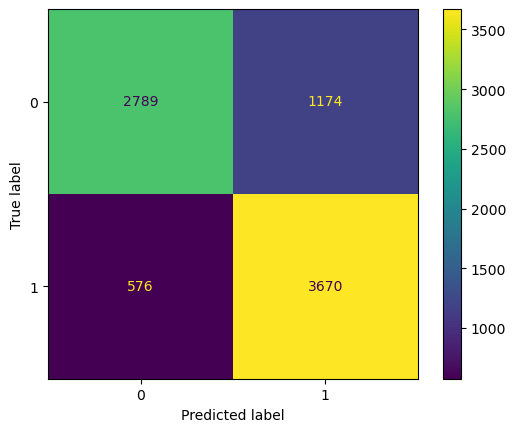

In [45]:
# Score model on testing set.
perf_measure_test(best_model_tvecnb, X_test, y_test)

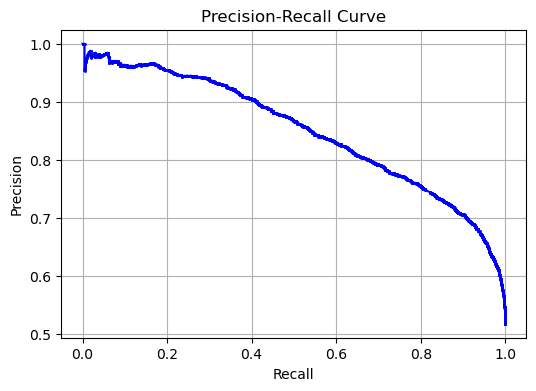

In [365]:
plot_precision_recall_curve(best_model_tvecnb, X_test, y_test)

### Findings - Naive Bayes
The Naive Bayes model seems quite stable with minimal overfitting. Between the count vectorizer and TF-IDF vectorizer, TVEC appears slightly more effective.


---
## 3.2.4 Random Forests
Next, the Random Forests model was explored. This model typically delivers high predictive performance, as it consists of an ensemble of multiple decision trees to reduce overfitting and increase generalization, leading to robust and accurate predictions. With that being said, overfitting is still common so we had to tweak the parameters to avoid major overfitting.

### Model 2A - CVEC, Random Forests

In [192]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer(tokenizer=tokenize_and_lemmatize, stop_words = list(final_stopwords), token_pattern=None)),
    ('rf', RandomForestClassifier())
])

In [193]:
pipe_cvecrf_params = {
    'cvec__max_features': [5_000],
    'cvec__min_df': [1],
    'cvec__max_df': [.90],
    'cvec__ngram_range': [(1,2)],
    'rf__n_estimators': [100],
    'rf__max_depth': [30],
    'rf__min_samples_split':[2]  # Adding regularization
}

In [194]:
gs_cvec_rf = GridSearchCV(pipe_cvec_rf,
                  param_grid=pipe_cvecrf_params,
                  cv=3,
                  error_score='raise') 

In [195]:
#Train pipeline on training data
gs_cvec_rf.fit(X_train, y_train)

best_score_cvecrf = gs_cvec_rf.best_score_
best_params_cvecrf = gs_cvec_rf.best_params_

best_model_cvecrf = gs_cvec_rf.best_estimator_

print(best_score_cvecrf)
print(best_params_cvecrf)
print(best_model_cvecrf)

0.7240924092409241
{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,


In [196]:
# Train the best model on the full training data
best_model_cvecrf.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and_lemmatize at 0x0000019078B72820>)),
                ('rf', RandomForestClassifier(max_depth=30))])

In [197]:
#pickle the models
pickle.dump(gs_cvec_rf, open('../model/gs_cvec_rf.pkl', 'wb'))
pickle.dump(best_model_cvecrf, open('../model/best_model_cvecrf.pkl', 'wb'))

In [198]:
# Score model on training set.
perf_measure_train(best_model_cvecrf, X_train, y_train)

MODEL PERFORMANCE:
Accuracy: 0.7749
F1 score: 0.8158


MODEL PERFORMANCE:
Accuracy: 0.7168
F1 score: 0.7683


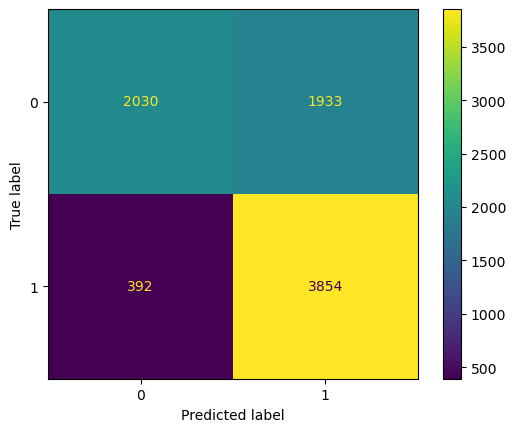

In [199]:
# Score model on testing set.
perf_measure_test(best_model_cvecrf, X_test, y_test)

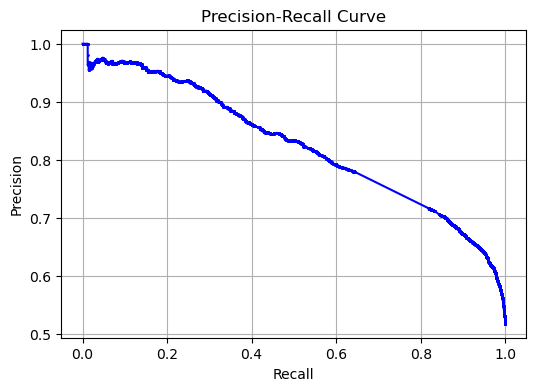

In [366]:
plot_precision_recall_curve(best_model_cvecrf, X_test, y_test)

---
### Model 2B - TF-IDF, Random Forests

In [ ]:
#load picked models
gs_tvecrf = pickle.load(open('../model/gs_tvecrf.pkl', 'rb'))
best_model_cvecrf = pickle.load(open('../model/best_model_cvecrf.pkl', 'rb'))

In [200]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer(tokenizer=tokenize_and_lemmatize, stop_words = list(final_stopwords), token_pattern=None)),
    ('rf', RandomForestClassifier())
])

# Search over the following values of hyperparameters:
pipe_tvec_rf_params = {
    'tvec__max_features': [5_000],
    'tvec__min_df': [1],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,2)],
    'rf__n_estimators': [100],
    'rf__max_depth': [30],
    'rf__min_samples_split': [2]
}

In [201]:
gs_tvecrf = GridSearchCV(pipe_tvec_rf,
                  param_grid=pipe_tvec_rf_params,
                  cv=3,
                  error_score='raise') 

In [202]:
#Train pipeline on training data
gs_tvecrf.fit(X_train, y_train)

best_score_tvecrf = gs_tvecrf.best_score_
best_params_tvecrf = gs_tvecrf.best_params_
best_model_tvecrf = gs_tvecrf.best_estimator_

print(best_score_tvecrf)
print(best_params_tvecrf)
print(best_model_tvecrf)

0.722952295229523
{'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
 

In [203]:
# Train the best model on the full training data
best_model_tvecrf.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and_lemmatize at 0x0000019078B72820>)),
                ('rf', RandomForestClassifier(max_depth=30))])

In [204]:
#pickle the models
pickle.dump(gs_tvecrf, open('../model/gs_tvecrf.pkl', 'wb'))
pickle.dump(best_model_tvecrf, open('../model/best_model_tvecrf.pkl', 'wb'))

In [205]:
# Score model on training set.
perf_measure_train(best_model_tvecrf, X_train, y_train)

MODEL PERFORMANCE:
Accuracy: 0.7858
F1 score: 0.8245


MODEL PERFORMANCE:
Accuracy: 0.7192
F1 score: 0.7698


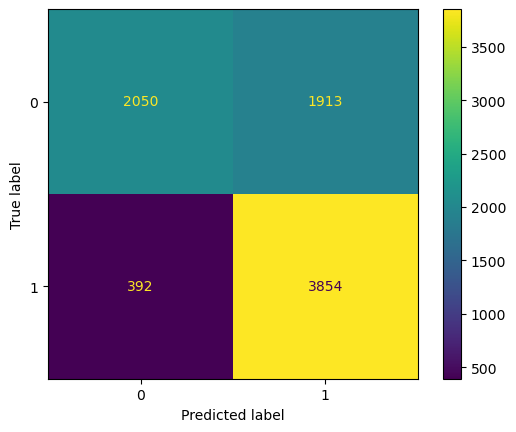

In [249]:
# Score model on testing set.
perf_measure_test(best_model_tvecrf, X_test, y_test)

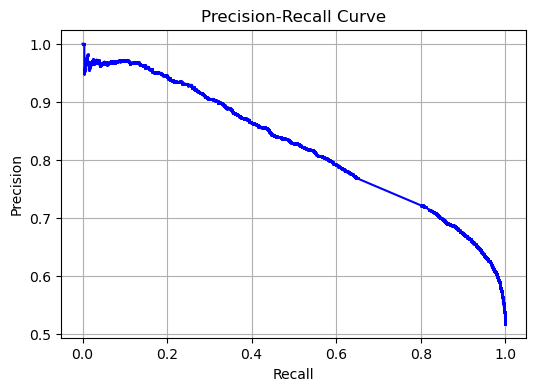

In [367]:
plot_precision_recall_curve(best_model_tvecrf, X_test, y_test)

### Findings - Random Forests
The random forests models, which were originally severely overfitted, managed to be tweaked till train and test scores were relatively similar. While this has resulted in a slightly lower accuracy and F1 score, the trade-off in accuracy and F1 scores result in a more stable model where train and test scores are similar. Between Count Vectorizer and TF-IDF vectorizer, again TVEC appears slightly more effective.

---
After fitting both model 1 (naive bayes) and model 2 (random forests) on both count vectorizer (CVEC) and TF-IDF vectorizer (TVEC), from the scores we can safely say that TVEC is more effective. This is likely to be because TVEC assigns a weight to each term based on its frequency in a specific document and its inverse frequency across all documents. This weighting helps emphasize terms that are important in a specific document while downplaying common terms that appear frequently across all documents. CVEC, on the other hand, simply counts the occurrences of terms in each document without considering their importance across the entire corpus. Hence for remaining models, we will just be using TVEC as our vectorizer.

## 3.2.5 ADABoost
### Model 3 - TF-IDF, ADAboost
Since the models we have tried so far (Logistic Regression, Naive Bayes, Random Forests) do not seem to be working well enough - our 

let's try a more complicated model ADABoost instead.

Theoretically, ADABoost could be an appropriate model due to its characteristics:
* Versatility: AdaBoost can be used with various base classifiers (weak learners), making it applicable to different NLP tasks.
* Can handle high-dimensional data: AdaBoost is effective in handling high-dimensional feature spaces often encountered in text data.
* Could avoid overfitting: Hopefully AdaBoost can help reduce overfitting since it combines multiple weak learners.

In [250]:
#load picked models
gs_ada = pickle.load(open('../model/gs_ada.pkl', 'rb'))
best_model_ada = pickle.load(open('../model/best_model_ada.pkl', 'rb'))

In [251]:
pipe_ada = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_and_lemmatize, stop_words = list(final_stopwords), token_pattern=None)),
    ('ada', AdaBoostClassifier())
])

pipe_ada_params = {
    'tfidf__max_df': [5_000, 6_000],          
    'tfidf__min_df': [2],                 
    'tfidf__ngram_range': [(1, 1), (1, 2)],      
    'ada__n_estimators': [100, 150],   
    'ada__learning_rate': [0.5]  
}

In [213]:
gs_ada = GridSearchCV(pipe_ada,
                  param_grid=pipe_ada_params,
                  cv=3,
                  error_score='raise') 

In [214]:
#Train pipeline on training data
gs_ada.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    'youre',
                                                                    'youve',
                                                                    'youll',
                                                                    'youd',
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'shes',
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', 'its',
                                                                    'its',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function tokenize_and_lemmatize at 0x0000019078B72820>)),
                                       ('ada', AdaBoostClassifier())]),
             param_grid={'ada__learning_rate': [0.1, 0.5, 1.0],
                         'ada__n_estimators': [100], 'tfidf__max_df': [5000],
                         'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]})

In [215]:
best_score_ada = gs_ada.best_score_
best_params_ada = gs_ada.best_params_
best_model_ada = gs_ada.best_estimator_

print(best_score_ada)
print(best_params_ada)
print(best_model_ada)

0.7133513351335133
{'ada__learning_rate': 0.5, 'ada__n_estimators': 100, 'tfidf__max_df': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=5000, min_df=2, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and_lemmatize at 0x0000

In [216]:
# Train the best model on the full training data
best_model_ada.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=5000, min_df=2, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function tokenize_and_lemmatize at 0x0000019078B72820>)),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.5, n_estimators=100))])

In [217]:
#pickle the models
pickle.dump(gs_ada, open('../model/gs_ada.pkl', 'wb'))
pickle.dump(best_model_ada, open('../model/best_model_ada.pkl', 'wb'))

In [218]:
# Score model on training set.
perf_measure_train(best_model_ada, X_train, y_train)

MODEL PERFORMANCE:
Accuracy: 0.7228
F1 score: 0.7746


MODEL PERFORMANCE:
Accuracy: 0.704
F1 score: 0.7606


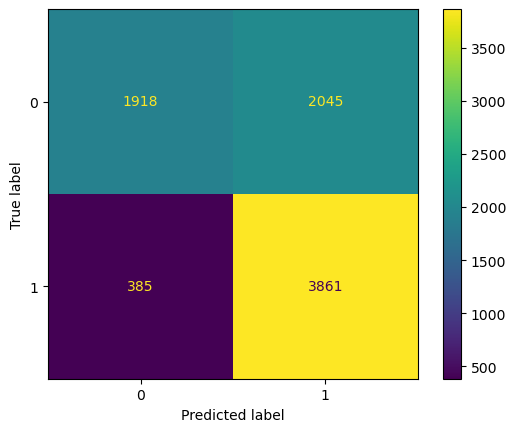

In [219]:
# Score model on testing set.
perf_measure_test(best_model_ada, X_test, y_test)

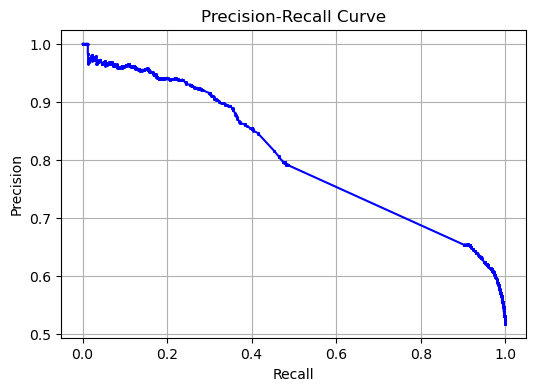

In [368]:
plot_precision_recall_curve(best_model_ada, X_test, y_test)

### Findings - ADABoost

Due to our limited time and computational power, we managed to tweak the parameters to minimise overfitting. However, the final model accuracy score is not ideal, with a test accuracy of 0.704 and test F1 score of 0.7606. 

There are also some cons of using ADAboost, including ADABoost being:
* Computationally Intensive: AdaBoost requires multiple rounds of training and updating, which can be computationally intensive and time-consuming, especially when dealing with a large number of weak learners.* 
Bias towards Easy Examples: AdaBoost may focus on misclassifying examples that are initially easy to classify correctly, which can limit its performance when dealing with more complex or ambiguous data.

---
## 3.2.6 Support Vector Machines (SVM)
### Model 4 - TF-IDF, SVM
Theoretically, SVM should also yield us a better score due to its characteristics of being:
* Effective in high-dimensional spaces
* Able to handle large feature sets like bag-of-words representations


In [ ]:
#load picked models
gs_tvecsvc = pickle.load(open('../model/gs_tvecsvc.pkl', 'rb'))
best_model_tvecsvc = pickle.load(open('../model/best_model_tvecsvc.pkl', 'rb'))

In [220]:
pipe_tvecsvc = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

# Define parameter grid for grid search
param_tvecsvc = {
    'tvec__max_df': [5_000],          
    'tvec__min_df': [1, 2],                 
    'tvec__ngram_range': [(1, 1), (1, 2)],     
    'svm__C': [1.0, 10.0, 100.0],               
    'svm__kernel': ['rbf']
}

In [221]:
gs_tvecsvc = GridSearchCV(pipe_tvecsvc,
                  param_grid=param_tvecsvc,
                  cv=3,
                  error_score='raise') 

In [222]:
#Train pipeline on training data
gs_tvecsvc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [1.0, 10.0, 100.0], 'svm__kernel': ['rbf'],
                         'tvec__max_df': [5000], 'tvec__min_df': [1, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [223]:
best_score_tvecsvc = gs_tvecsvc.best_score_
best_params_tvecsvc = gs_tvecsvc.best_params_
best_model_tvecsvc = gs_tvecsvc.best_estimator_

print(best_score_tvecsvc)
print(best_params_tvecsvc)
print(best_model_tvecsvc)

0.7761776177617762
{'svm__C': 100.0, 'svm__kernel': 'rbf', 'tvec__max_df': 5000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}
Pipeline(steps=[('tvec', TfidfVectorizer(max_df=5000)), ('svm', SVC(C=100.0))])


In [224]:
# Train the best model on the full training data
best_model_tvecsvc.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(max_df=5000)), ('svm', SVC(C=100.0))])

In [225]:
#pickle the models
pickle.dump(gs_tvecsvc, open('../model/gs_tvecsvc.pkl', 'wb'))
pickle.dump(best_model_tvecsvc, open('../model/best_model_tvecsvc.pkl', 'wb'))

In [226]:
# Score model on training set.
perf_measure_train(best_model_tvecsvc, X_train, y_train)

MODEL PERFORMANCE:
Accuracy: 0.9975
F1 score: 0.9976


MODEL PERFORMANCE:
Accuracy: 0.7884
F1 score: 0.8011


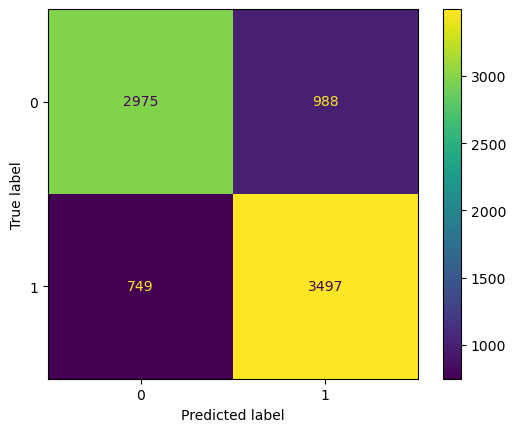

In [227]:
# Score model on testing set.
perf_measure_test(best_model_tvecsvc, X_test, y_test)

### Findings - Support Vector Machines (SVM)

The SVM model managed to yield one of the higher test scores - Accuracy being 0.7884 and F1 being 0.8011. However, there is massive overfitting occuring, with train accuracy and F1 scores being around 0.9976. This would not be a strong model to select for production, as it would lead to poor generalization to unseen or new data. The model's predictions would also be unreliable and unpredictable.

---
## 3.2.7 Summary of Model Performance

|No|Model|Vectorizer|Train Accuracy, F1 Score|Test Accuracy, F1 Score|
|---|---|---|---|---|
|0|Base model <br>Logistic Regression|CVEC|0.9112 (Acc)|0.7481 (Acc)|
|1A|Naive Bayes|CVEC|0.7793 (Acc)<br>0.8002 (F1)|0.7752 (Acc)<br>0.7973 (F1)|
|**1B**|**Naive Bayes**|**TF-IDF**|**0.8041 (Acc)<br>0.8226 (F1)**|**0.7868 (Acc)<br>0.8075 (F1)**|
|2A|Random Forest|CVEC|0.7749 (Acc)<br>0.8158 (F1)|0.7168 (Acc)<br>0.7683 (F1)|
|2B|Random Forest|TF-IDF|0.7858 (Acc)<br>0.8245 (F1)|0.7192 (Acc)<br>0.7698 (F1)|
|3|ADABoost|TF-IDF|0.7228 (Acc)<br>0.7746 (F1)|0.704 (Acc)<br>0.7606 (F1)|
|4|SVM|TF-IDF|0.9975 (Acc)<br>0.9976 (F1)|0.7884 (Acc)<br>0.8011 (F1)|

We tried various binary classification models, including Logistic Regression, Naive Bayes, Random Forests, ADABoost, and Support Vector Machines. All the models here outperformed the base model accuracy score of 0.7481. As the aim of the model is to be able to successfully perform binary classification on our text posts and comments, we select the model with the highest accuracy and F1 score -  The **Naive Bayes with TF-IDF vectorizer** as our production model. It is likely that our NLP model does not require such a complex model, and the simpler models like Logistic Regression and Naive Bayes would suffice and produce good results if trained with the right parameters.

Considering our limitations with respect to time and computational power, the top-performing Naive Bayes model exhibits decent performance metrics on both the training and testing datasets. With a training accuracy of 0.7928 and an F1 score of 0.8127, and a testing accuracy of 0.7868 and an F1 score of 0.8075, the model demonstrates a consistent level of accuracy and balanced precision and recall. 

---
## 3.2.8 Analysis of NB model's Coefficients
We use our top-performing model, the Naive Bayes with TF-IDF vectorizer, to extract the model's coefficients. The coef_df DataFrame contains the log probabilities of features. From the dataframe, we can identify the log probability of each feature occurring in a specific class.

In [260]:
# Get the best trained NB model
best_nb_model = gs_tvecnb.best_estimator_.named_steps['nb']

# Get the log probabilities of features for each class
log_probabilities = best_nb_model.feature_log_prob_

# Get the feature names from the TF-IDF vectorizer
feature_names = gs_tvecnb.best_estimator_.named_steps['tvec'].get_feature_names_out()

# Create a DataFrame to store feature names and log probabilities
coef_df = pd.DataFrame(log_probabilities.T, columns=gs_tvecnb.best_estimator_.classes_, index=feature_names)
coef_df

,0,1
_,-8.882871,-9.191981
ability,-8.339503,-7.986223
able,-6.918258,-6.901820
able explain,-9.720080,-9.640076
able find,-9.714385,-9.497676
...,...,...
yr,-9.040552,-9.003465
yup,-8.736032,-8.407684
z,-9.387983,-9.573522
zero,-8.097101,-8.004733


### Top Predictor Words
By extracting the words with the highest difference in log proabilities, we can determine which words would be most effective in helping to categorize comments into r/datascience or r/dataengineering.

In [265]:
# Calculate the absolute difference in log probabilities between class 1 and class 0
coef_df['difference'] = abs(coef_df[1] - coef_df[0])
sorted_coef_df = coef_df.sort_values(by='difference', ascending=False)

# Print the top words with the greatest difference
top_words = sorted_coef_df.head(20) 
print(top_words)

                       0          1  difference
dbt            -6.192987 -10.263246    4.070259
airflow        -6.371461  -9.962129    3.590669
redshift       -7.115901 -10.517227    3.401326
dagster        -7.272653 -10.517227    3.244574
delta          -6.791237  -9.747786    2.956549
terraform      -7.469564 -10.380267    2.910703
fivetran       -7.454377 -10.314536    2.860158
warehouse      -6.735416  -9.592833    2.857417
schema         -6.743920  -9.588713    2.844792
synapse        -7.676225 -10.517227    2.841002
apache         -7.372700 -10.176903    2.804202
statistical    -9.876933  -7.120071    2.756861
regression     -9.861487  -7.122860    2.738627
sa             -8.966666  -6.249775    2.716891
tidyverse     -10.467179  -7.766549    2.700631
snowflake      -6.181623  -8.881488    2.699866
stats          -9.200467  -6.530878    2.669589
dlt            -7.849318 -10.517227    2.667910
orchestration  -7.727381 -10.385457    2.658075
flink          -7.883419 -10.517227    2

Analysing the top 20 words with the largest coefficient differences, we can see that most words (including the first 10 words!) all have larger coefficients in Class 0, or r/dataengineering. For example, the log probability of the first term "dbt" occuring in r/datascience is approx -6.19, while the log probability of "dbt" occuring in r/dataengineering is -10.3; suggesting "dbt" is more indicative of being part of r/dataengineering. 

Through these log probabilities, we gain insights into which words are more strongly associated with each class according to the Naive Bayes model. However, we are to note is that these values are not coefficients in the traditional sense and should be interpreted in the context of Naive Bayes' probabilistic approach to classification.

---
# 3.3 Conclusion

## 3.3.1 Addressing the Problem Statement

* In this project, through EDA, we gained initial insights into the levels of interest in data science and data engineering that would help General Assembly (GA) solidify the value proposition of establishing a discussion platform for existing students and prospective individuals keen on enrolling in GA bootcamps. The development of a natural language processing (NLP) model to automatically classify comments into the categories of Data Science and Data Engineering would help address downstream workflow concerns of having to sort and categorize comments from the discussion platform.

* Through the use of r/datascience and r/dataengineering subreddits, we have successfully trained and tested various binary classification models, including Logistic Regression, Naive Bayes, Random Forests, ADABoost, and Support Vector Machines. Our evaluation metrics, including accuracy and F1 score, have enabled a comprehensive assessment of model performance, providing valuable insights into their effectiveness. 

* Our top model (Naive Bays, using TF-IDF vectorizer) has a training accuracy of 0.7928 and an F1 score of 0.8127, and a testing accuracy of 0.7868 and an F1 score of 0.8075, demonstrating a consistent level of accuracy and balanced precision and recall. The problem statement highlighted the need for a robust NLP model to streamline the process of categorizing discussions from the General Assembly open platform, and the performance metrics proved the model being able to accurately classify comments to a commendable accuracy level.

* This data-driven approach supports informed decision-making and enhances GA's ability to cater to the needs and preferences of students, thus solidifying its position as a pioneering tech education institution.

---
## 3.3.2 Limitations and Recommendations
For further improvements and development downstream, we would like to point out several limitations of the model as well as some recommendations:

**1) Generalization to New Domains<br>**
* The current model is tailored to categorize discussions specifically within the domains of Data Science and Data Engineering. Further development is needed to adapt the model for other domains or to handle more diverse and nuanced topics. 
* GA could consider further developing a multiclassification model that also includes classification of comments relating to Software Engineering, or other increasing popular data roles in the future.

**2) Improve the model on contextual understanding<br>**
* Since we trained the model through subreddits, the model might struggle with ambiguous or context-dependent language, leading to misclassifications when faced with intricate sentence structures or word meanings. If the discussion platform is mainly catering to GA current and potential students who are based in Singapore, then we would have to consider the use of Singlish on the discussion platform. The topics discussed on subreddits as compared to GA's discussion platform may also be quite different.
* In future, we could explore advanced NLP techniques, such as transformer-based models (e.g., BERT, GPT), which excel at capturing contextual information and resolving ambiguities. We should also periodically update the model with new data (from the actual GA discussion platform) to ensure it remains relevant and effective in classifying current discussions.

**3) A standalone Sentiment Analysis study <br>**
* As we can see from our quick sentiment analysis, the study was useful to gain insights into sentiments expressed within the discussions. To achieve a more comprehensive understanding, a more detailed and thorough sentiment analysis should be conducted. While VADER has been used effectively in this study, it is imperative to establish its reliability by performing a rigorous assessment of its classifications.
* One approach to ensuring the accuracy of VADER's classifications involves conducting a manual review of a representative sample of VADER's sentiment assignments. By manually analyzing a subset of comments and comparing the manual assessment with VADER's classifications, we can quantify VADER's accuracy and identify any discrepancies.
* This validation process will provide insights into the model's performance and highlight areas where adjustments or refinements may be necessary. This validation step is crucial for building trust in the sentiment analysis results, establishing the reliability of sentiment classifications will enable more confident utilization of sentiment analysis outcomes for strategic decision-making in the future.
* Some additional business use case scenarios for our sentiment analysis model would include: helping to Tailor Course Offerings, Strategic Marketing, etc.
.